In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/raw/StressLevelDataset.csv')

In [3]:
df.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


In [4]:
df.isna().sum()

anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

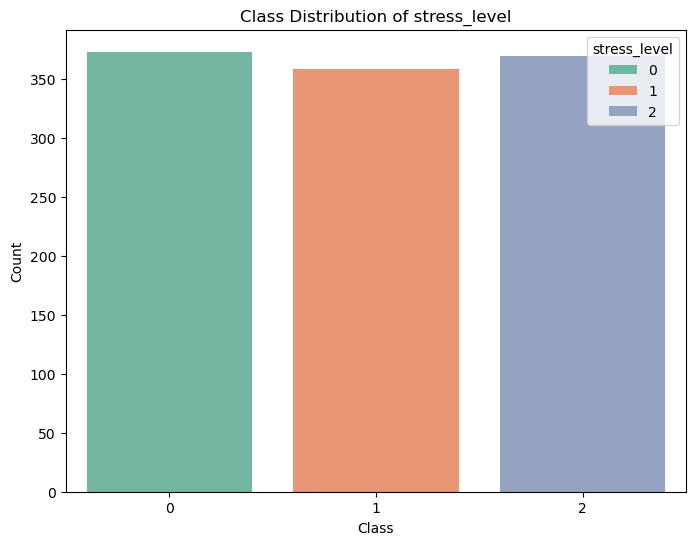

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='stress_level', data=df, palette='Set2',hue='stress_level')
plt.title(f'Class Distribution of stress_level')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


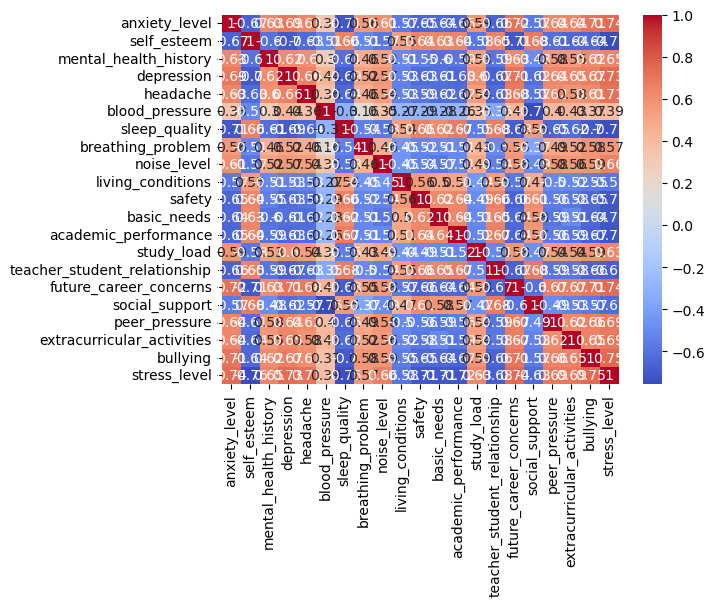

In [6]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [9]:
def encode(df):
    label_encoders = {}
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) 
        label_encoders[col] = le
    return df, label_encoders

def impute(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    print(f"\n--- Imputed Data using KNN with {n_neighbors} neighbors ---")
    df_imputed['Survived'] = df_imputed['Survived'].astype(int)
    return df_imputed

def scale(df, target):
    scaler = StandardScaler()
    y = df[target]
    x = df.drop(target,axis=1)
    numerical_cols = x.select_dtypes(include=['float64', 'int64']).columns
    x[numerical_cols] = scaler.fit_transform(x[numerical_cols])
    print("\n--- Scaled Numerical Columns using StandardScaler ---")
    return pd.concat([x,y],axis=1)

def map_column(dataset, mapping_dict):
    """
    General function to map values in a specific column based on a provided mapping dictionary.

    Parameters:
    dataset (pd.DataFrame): The dataset containing the column to be mapped.
    mapping_dict (dict): A dictionary defining the mapping from original values to new values.

    Example:
    map_column(dataset, 'stress_level', {1: 0, 2: 50, 3: 100})
    """
    return dataset.map(mapping_dict)


In [10]:
# df = scale(df, 'stress_level')

In [11]:
df['stress_level'].value_counts()

stress_level
0    373
2    369
1    358
Name: count, dtype: int64

In [12]:
df['stress_level'] = map_column(df['stress_level'], {0: 0, 1: 50, 2: 100})

In [13]:
df['stress_level'].value_counts()

stress_level
0      373
100    369
50     358
Name: count, dtype: int64

In [14]:
X = df.drop('stress_level',axis=1)
y = df['stress_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
y_test.value_counts()

stress_level
0      76
50     73
100    71
Name: count, dtype: int64

In [16]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor

In [17]:
model = LGBMRegressor()
model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 880, number of used features: 20
[LightGBM] [Info] Start training from score 50.056818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json

In [19]:
predict = model.predict(X_test)

In [20]:
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 329.6169697245981
Mean Absolute Error: 7.753210113124413
R-squared: 0.8025256217277357


In [21]:
metrics_dict = {
    "Mean Squared Error": mse,
    "Mean Absolute Error": mae,
    "R-squared": r2
}

# Export the dictionary to a JSON file
with open('metrics.json', 'w') as json_file:
    json.dump(metrics_dict, json_file, indent=4)

print("Metrics exported to metrics.json")

Metrics exported to metrics.json


In [22]:
import pickle

In [23]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model,f)

In [24]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
model

LGBMRegressor()

In [26]:
import shap

/Users/fauzanghaza/Documents/[04]Student/[03]Competition/[06]IFest/Machine_learning/stress-checker-model/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
coba = X_test.tail(1)

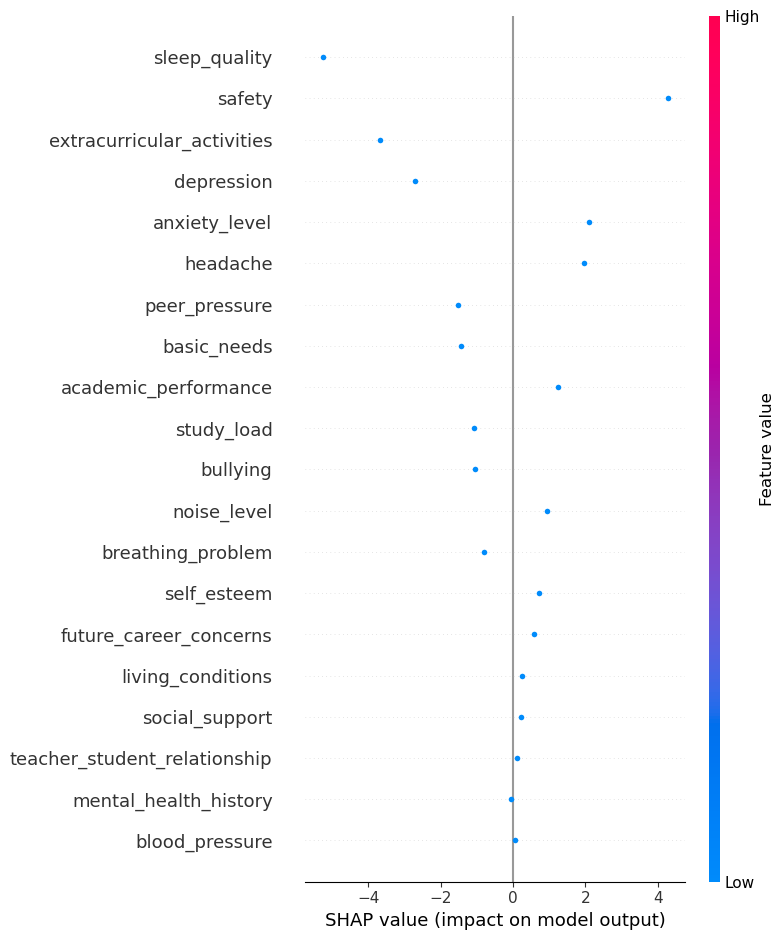

In [28]:
import shap
import matplotlib.pyplot as plt

# Assuming you have a trained model and a dataset
explainer = shap.Explainer(model)
shap_values = explainer(coba)

# Use a summary plot with Matplotlib (static plot)
shap.summary_plot(shap_values, coba)